Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "XAVIER MALTAS TARRIDAS"
COLLABORATORS = "OSCAR BUISAN"

---

![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png)  ![Python Logo](http://spark-mooc.github.io/web-assets/images/python-logo-master-v3-TM-flattened_small.png)
# Activitat 4: Octubre 2023

## Extracció de coneixement de fonts de dades heterogènies mitjançant Spark SQL, RDDs i GraphFrames

En aquesta pràctica anem a introduir els elements que ofereix Spark per treballar amb estructures de dades. Veurem des d'estructures molt simples fins a estructures complexes,n els camps poden al seu torn tenir camps imbricats. En concret utilitzarem dades de twitter capturats en el context de les eleccions generals a Espanya de l'28 d'Abril de 2019. La pràctica està estructurada de la següent manera:
- **Part 0:** Configuració de l'entorn
- **Part 1:** Introducció a data frames estructurats i com operar extreure informació *(2 punts)*
    - **Part 1.1:** Importa les dades *(0.25 punts)*
    - **Part 1.2:** *Queries* sobre sobre data frames complexos *(1.75 punts)*
        - **Part 1.2.1:** Queries SQL *(0.75 punts)*
        - **Part 1.2.2:** Queries sobre el pipeline *(1 punt)*
- **Part 2:** Bases de dades HIVE i operacions complexes *(3 punts)*
    - **Part 2.1:** Bases de dades Hive *(0.25 punts)*
    - **Part 2.2:** Més enllà de les transformacions SQL *(2.75 punts)*
        - **Part 2.2.1:** Tweets per població  *(1.25 punts)*
            - **Part 2.2.1.1:** Utilizant SQL *(0.25 punts)*
            - **Part 2.2.1.2:** Utilizant RDD *(1 punt)*
        - **Part 2.2.2:** Comptar hashtags *(1.5 punts)*
- **Part 3:** Sampling *(1.5 punts)*
    - **Part 3.1:** Homogeni *(0.5 punt)*
    - **Part 3.2:** Estratificat *(1 punts)*
- **Part 4**: Introducció a les dades relacionals *(1.5 punts)*
    - **Part 4.1:** Generar la xarxa de retweets *(1 punt)*
        - **Part 4.1.1**: Construcció de l'edgelist *(0.5 punts)*
        - **Part 4.1.2**: Centralidad de grau *(0.5 punts)*
    - **Part 4.2:** Anàlisi de xarxes utilitzant GraphFrames *(0.5 punt)*
- **Part 5**: Preguntes teòriques *(2 punts)*    

## **Part 0:** Configuració del entorn

In [2]:
import findspark
findspark.init()

In [3]:
import re
import os
import pandas as pd
from matplotlib import pyplot as plt
from math import floor
from pyspark import SparkConf, SparkContext, SQLContext, HiveContext
from pyspark.sql import Row

In [4]:
SUBMIT_ARGS = "--jars /opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/jars/graphframes_graphframes-0.7.0-spark2.4-s_2.11.jar pyspark-shell"

os.environ["PYSPARK_SUBMIT_ARGS"] = SUBMIT_ARGS

conf = SparkConf()
conf.setMaster("local[1]")
# Introduïu el nom de l'app PAC3_ seguit del vostre nom d'usuari
conf.setAppName("PAC3_xmaltast")
sc = SparkContext(conf=conf)

## **Part 1:** Introducció a DataFrames estructurats i operacions sobre ells.

Com ja s'ha esmentat, en aquesta pràctica utilitzarem dades de Twitter que es van recollir durant les eleccions generals a Espanya de l'28 d'abril de 2019. Com veurem, els tweets tenen una estructura interna força complexa tot i que s'ha simplificat una mica en aquesta pràctica.

### **Part 1.1:** Importa les dades

El primer que anem ha aprendre és com importar aquest tipus de dades al nostre entorn. Un dels tipus d'arxius més comuns per guardar aquest format d'informació és [l'estructura JSON] (https://en.wikipedia.org/wiki/JSON). Aquesta estructura permet registrar informació en text pla de diferents objectes seguint una estructura de diccionari on cada camp té assignat una clau i un valor. L'estructura pot ser imbricada, o sigui que una clau pot tenir com a valor una altra estructura tipus diccionari.

Spark SQL permet llegir dades de molts formats diferents. En aquesta ocasió, se us demana que llegiu un [fitxer JSON](https://spark.apache.org/docs/2.4.0/sql-data-sources-json.html) de la ruta ```/aula_M2.858/data/tweets28a_sample.json```. Aquest fitxer conté un petit *sample*, 0.1% de la base de dades completa (en un següent apartat veurem com realitzar aquest *samplejat*). En aquesta ocasió a la funció read no cal especificar l'estructura de l'DataFrame ja que la funció de lectura la inferirà automàticament.

**Esquema**

```Python
sqlContext = SQLContext(sc)
tweets_sample = sqlContext.read.<FILL IN>

print("Loaded dataset contains %d tweets" % tweets_sample.count())
```

In [5]:
from pyspark.sql import SparkSession

# SparkContext creation
sqlContext = SQLContext(sc)

# Path to the JSON file
json_file_path = "/aula_M2.858/data/tweets28a_sample.json"

# Read JSON file into a DataFrame
tweets_sample = sqlContext.read.json(json_file_path)

# Display the number of tweets
print("Loaded dataset contains %d tweets" % tweets_sample.count())

Loaded dataset contains 27268 tweets


In [6]:
assert tweets_sample.count() == 27268, "Incorrect answer"

El següent pas és mostrar l'estructura del dataset que acabem de carregar.Podeu obtenir la informació sobre com està estructurat el DataTable utilitzant el mètode ```printSchema()```de la variable `tweets_sample`.

In [7]:
# Show the structure of the dataset
tweets_sample.printSchema()

root
 |-- _id: string (nullable = true)
 |-- created_at: long (nullable = true)
 |-- lang: string (nullable = true)
 |-- place: struct (nullable = true)
 |    |-- bounding_box: struct (nullable = true)
 |    |    |-- coordinates: array (nullable = true)
 |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |-- element: double (containsNull = true)
 |    |    |-- type: string (nullable = true)
 |    |-- country_code: string (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- place_type: string (nullable = true)
 |-- retweeted_status: struct (nullable = true)
 |    |-- _id: string (nullable = true)
 |    |-- user: struct (nullable = true)
 |    |    |-- followers_count: long (nullable = true)
 |    |    |-- friends_count: long (nullable = true)
 |    |    |-- id_str: string (nullable = true)
 |    |    |-- lang: string (nullable = true)
 |    

Podeu observar que l'estructura de la piulada conté múltiples camps imbricats. Heu de familiaritzar-vos amb aquesta estructura ja que serà la què utilitzarem durant tota aquesta pràctica. Recordeu també que no tots els tweets tenen tots els camps, com ara la ubicació (camp ```place```). Quan això passa el camp és ```NULL```. Podeu veure mes informació sobre aquest tipus de dades en [aquest enllaç](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object).

### **Part 1.2:** *Queries* sobre sobre data frames complexos



En aquesta part de la pràctica veurem com fer consultes sobre el dataset que acabem de carregar. A la primera part anem ha utilitzar [sentències *SQL*](https://www.w3schools.com/sql/default.asp) (com les utilitzades en la majoria de bases de dades relacionals). Per finalitzar veurem un sistema alternatiu per fer consultes utilitzant una aproximació més semblant a la que vau veure a la primera PAC.

#### **Part 1.2.1:** Queries SQL

En primer lloc anem a registrar el nostre DataFrame com una taula de SQL anomenat ```tweets_sample```. Com que és possible que repeteixis aquesta pràctica diverses vegades, anem a prendre la precaució d'eliminar qualsevol taula existent en primer lloc.

Podem eliminar qualsevol taula SQL existent `tweets_sample` usant la sentència SQL: `DROP TABLE IF EXISTS tweets_sample`. Per executar una ordre sql només heu de fer servir el mètode SQL de l'objecte context, en aquest cas `sqlContext`.

Un cop executat el pas anterior, podem registrar el nostre DataFrame com una taula de SQL utilitzant [sqlContext.registerDataFrameAsTable()](https://spark.apache.org/docs/2.4.0/api/python/pyspark.sql.html#pyspark.sql.SQLContext.registerDataFrameAsTable).

**Esquema**
```Python
sqlContext.sql(<FILL IN>)
sqlContext.registerDataFrameAsTable(<FILL IN>)
```

In [8]:
# Drop existing 'tweets_sample' table if it exists
sqlContext.sql("DROP TABLE IF EXISTS tweets_sample")

# Register the DataFrame as a SQL table named 'tweets_sample'
tweets_sample.createOrReplaceTempView("tweets_sample")

# Display the count of rows in the registered table
#table_count = sqlContext.sql("SELECT * FROM tweets_sample").count()
table_count = sqlContext.sql("SELECT COUNT(*) FROM tweets_sample").collect()[0][0]
print("Number of rows in 'tweets_sample' table: {}".format(table_count))

Number of rows in 'tweets_sample' table: 27268


In [9]:
assert sqlContext.sql("SELECT * FROM tweets_sample").count() == 27268, "Incorrecct answer"

Ara es demana que creeu una taula ```users_agg``` amb [la informació agregada] (https://www.w3schools.com/sql/sql_groupby.asp) dels usuaris que tinguin definit el seu idioma (``` user.lang```) com espanyol (```es```). En concret se us demana que la taula contingui les següents columnes:
- **screen_name:** nom de l'usuari
- **friends_count:** nombre màxim (veure nota) de persones a les que segueix
- **tweets:** nombre de tweets realitzats
- **followers_count:** nombre màxim (veure nota) persones que segueixen a l'usuari.

L'ordre en què s'han de mostrar els registres és ordre descendent d'acord amb el nombre de tweets.

***Nota:*** és important que us fixeu en què el nom de *friends* i *followers* pot diferir al llarg de l'adquisició de dades. En aquest cas anem a utilitzar la funció d'agregació ```MAX``` sobre cadascun d'aquests camps per evitar segmentar l'usuari en diverses instàncies.

**Esquema**
```Python
users_agg = sqlContext.sql(<FILL IN>)
users_agg.limit(10).show()
```

In [10]:
# Create the users_agg table with aggregated information
query = """
SELECT
    user.screen_name AS screen_name,
    MAX(user.friends_count) AS friends_count,
    COUNT(*) AS tweets,
    MAX(user.followers_count) AS followers_count
FROM
    tweets_sample
WHERE
    user.lang = 'es'
GROUP BY
    user.screen_name
ORDER BY
    tweets DESC
"""

# Execute the query and create the users_agg DataFrame
users_agg = sqlContext.sql(query)

# Show the top 10 records
users_agg.limit(10).show()


+---------------+-------------+------+---------------+
|    screen_name|friends_count|tweets|followers_count|
+---------------+-------------+------+---------------+
|       anaoromi|         6258|    16|           6774|
|    RosaMar6254|         6208|    14|           6245|
|        lyuva26|         3088|    13|           3732|
|PisandoFuerte10|         2795|    12|           1752|
|     carrasquem|          147|    12|            215|
|       jasalo54|         1889|    11|            689|
|  PabloChabolas|         4925|     9|           4042|
|      lolalailo|         4922|     9|           3738|
|     Lordcrow11|         5002|     9|           3069|
|    DuroBelinda|         5242|     9|           5778|
+---------------+-------------+------+---------------+



In [11]:
output = users_agg.first()
assert output.screen_name == 'anaoromi' and output.friends_count == 6258 and output.tweets == 16 and output.followers_count == 6774, "Incorrect output"

Imagineu ara que volem combinar la informació que acabem de generar amb informació sobre el nombre de vegades que un usuari ha estat retuitejat. Per fer aquest tipus de combinacions necessitem recórrer a l'[```JOIN``` de taules](https://www.w3schools.com/sql/sql_join.asp). Primer hem de registrar la taula que acabem de generar en el context SQL. Recordeu que primer heu de comprovar si la taula existeix i en cas afirmatiu eliminar-la. La taula heu de registrar-la sota el nom de ```user_agg```.

In [12]:
# Check if 'user_agg' table exists and drop it if it does
if sqlContext.sql("SHOW TABLES LIKE 'user_agg'").count() > 0:
    sqlContext.sql("DROP TABLE user_agg")

# Register 'users_agg' DataFrame as a SQL table named 'user_agg'
users_agg.createOrReplaceTempView("user_agg")

# Show the output of the registered 'user_agg' table and the count
output_user_agg = sqlContext.sql("SELECT * FROM user_agg")
user_agg_count = output_user_agg.count()
print("Number of rows in 'user_agg' table: {}".format(user_agg_count))
output_user_agg.show()

Number of rows in 'user_agg' table: 17925
+---------------+-------------+------+---------------+
|    screen_name|friends_count|tweets|followers_count|
+---------------+-------------+------+---------------+
|       anaoromi|         6258|    16|           6774|
|    RosaMar6254|         6208|    14|           6245|
|        lyuva26|         3088|    13|           3732|
|     carrasquem|          147|    12|            215|
|PisandoFuerte10|         2795|    12|           1752|
|       jasalo54|         1889|    11|            689|
|  Rafa_eltorete|          908|     9|           1060|
| locuspolitikus|        11261|     9|          10244|
|      kikyosanz|          154|     9|            273|
|  PabloChabolas|         4925|     9|           4042|
|     Lordcrow11|         5002|     9|           3069|
|      lolalailo|         4922|     9|           3738|
|    DuroBelinda|         5242|     9|           5778|
|        Fermirv|         3031|     8|           1731|
| BlaancaNiieves|      

In [13]:
assert sqlContext.sql("SELECT * FROM user_agg").count() == 17925, "Incorrect answer"

Un cop registrada es demana que combineu aquesta taula i la taula ```tweets_sample``` servir un ``` INNER JOIN``` per obtenir una nova taula amb la següent informació:
- ***screen_name:*** nom d'usuari
- ***friends_count:*** nombre màxim de persones a les que segueix
- ***followers_count:*** nombre màxim de persones que segueixen a l'usuari.
- ***tweets:*** nombre de tweets realitzats per l'usuari.
- ***retweeted:*** nombre de retweets obtinguts per l'usuari.
- ***ratio_tweet_retweeted:*** ràtio de retweets per nombre de tweets publicats $\frac{retweets}{tweets}$

La taula resultate ha d'estar ordenada de manera descendent segons el valor de la columna```ratio_tweet_retweeted```

**Esquema**
```Python
retweeted = sqlContext.sql(<FILL IN>)

retweeted.limit(10).show()
```

In [14]:
# Perform INNER JOIN to combine 'user_agg' and 'tweets_sample'
query = """ 
SELECT 
    ts.rt_name as screen_name,
    MAX(u.tweets) as tweets,
    MAX(ts.retweeted) as retweeted,
    MAX(u.friends_count) as friends_count,
    MAX(u.followers_count) as followers_count,
    MAX(ts.retweeted/u.tweets) as ratio_tweet_retweeted 
FROM user_agg u 
INNER JOIN
(
    SELECT 
        retweeted_status.user.screen_name as rt_name,
        COUNT(retweeted_status.user.screen_name) as retweeted
    FROM tweets_sample 
    GROUP BY retweeted_status.user.screen_name
) ts 
ON u.screen_name = ts.rt_name
GROUP BY ts.rt_name 
ORDER BY retweeted DESC
"""

# Execute the query and create the 'retweeted' DataFrame
retweeted = sqlContext.sql(query)

# Show the top 10 records
retweeted.limit(10).show()

+--------------+------+---------+-------------+---------------+---------------------+
|   screen_name|tweets|retweeted|friends_count|followers_count|ratio_tweet_retweeted|
+--------------+------+---------+-------------+---------------+---------------------+
|          PSOE|     1|      155|        13635|         671073|                155.0|
|  CiudadanosCs|     1|      117|        92910|         511896|                117.0|
|     JuntsXCat|     1|       73|          202|          88515|                 73.0|
|  PartidoPACMA|     1|       63|         1498|         232932|                 63.0|
|  pablocasado_|     1|       50|         4567|         238926|                 50.0|
|voxnoticias_es|     1|       44|         2146|          29582|                 44.0|
|RaiLopezCalvet|     1|       43|         7579|          13574|                 43.0|
|        iunida|     1|       39|        10225|         558318|                 39.0|
|        Xuxipc|     1|       37|          311|       

In [15]:
# Filter the 'retweeted' DataFrame for a specific 'screen_name'
specific_user = retweeted.filter(retweeted.screen_name == 'PSOE')

# Show the filtered DataFrame
specific_user.show()

+-----------+------+---------+-------------+---------------+---------------------+
|screen_name|tweets|retweeted|friends_count|followers_count|ratio_tweet_retweeted|
+-----------+------+---------+-------------+---------------+---------------------+
|       PSOE|     1|      155|        13635|         671073|                155.0|
+-----------+------+---------+-------------+---------------+---------------------+



In [16]:
output = retweeted.first()
assert output.screen_name == 'PSOE' and output.friends_count == 13635 and output.tweets == 1 and output.followers_count == 671073 and output.ratio_tweet_retweeted == 155.0 and output.retweeted == 155, "Incorrect output"

#### **Part 1.2.2:** Queries mijançant el pipeline

Les taules de Spark SQL ofereixen un altre mecanisme per aplicar les transformacions i obtenir resultats similars als que s'obtindria aplicant una consulta SQL. Per exemple utilitzant el següent pipeline obtindrem el text de tots els tweets en espanyol:

```
tweets_sample.where("lang == 'es'").select("text")
```

L'anterior instrucció és equivalent a la següent sentència SQL:
```
SELECT text
FROM tweets_sample
WHERE lang == 'es'
```

Podeu consultar el [API de spark SQL](https://spark.apache.org/docs/2.4.0/api/python/pyspark.sql.html) per trobar més informació sobre com utilitzar les diferents transformacions sobre taules.

En aquest exercici es demana que repliqueu la query obtinguda a l'apartat anterior generant primerament la taula ```users_agg```. Podeu utilitzar les transformacions ```where```, ```select``` (o ```selectExpr```), ```groupBy```, ```count```, ```agg``` i ```orderBy```

**Esquema**
```Python
users = tweets_sample.where(<FILL IN>).select(<FILL IN>)

users_agg = users.groupBy(<FILL IN>)\
                 .agg(<FILL IN>)\
                 .orderBy(<FILL IN>)

users_agg.limit(10).show()
```

In [17]:
from pyspark.sql.functions import count

# Generate 'users' DataFrame
users = tweets_sample.where(tweets_sample["user.lang"] == 'es').select("user.id_str","user.screen_name","user.lang","user.friends_count", "user.followers_count")

# Generate 'users_agg' DataFrame
users_agg = users.groupBy("screen_name","lang")\
                 .agg({"friends_count":"max","followers_count":"max","screen_name":"count"})\
                 .orderBy("count(screen_name)",ascending=False)

# Show the top 10 records
users_agg.limit(10).show()


+---------------+----+------------------+------------------+--------------------+
|    screen_name|lang|max(friends_count)|count(screen_name)|max(followers_count)|
+---------------+----+------------------+------------------+--------------------+
|       anaoromi|  es|              6258|                16|                6774|
|    RosaMar6254|  es|              6208|                14|                6245|
|        lyuva26|  es|              3088|                13|                3732|
|     carrasquem|  es|               147|                12|                 215|
|PisandoFuerte10|  es|              2795|                12|                1752|
|       jasalo54|  es|              1889|                11|                 689|
| locuspolitikus|  es|             11261|                 9|               10244|
|      kikyosanz|  es|               154|                 9|                 273|
|  Rafa_eltorete|  es|               908|                 9|                1060|
|      lolalailo

In [18]:
output = users_agg.first()
assert output.screen_name == 'anaoromi'

Si us fixeu veureu que el nom de les columnes no correspon amb l'obtingut anteriorment, podeu canviar el nom d'una columna determinada utilitzant la transfomació ```withColumnRenamed```. Canvieu el nom de les columnes perquè coincideixin amb l'apartat anterior i les guardeu en una variable ```user_agg_new```.

**Esquema**
```Python
users_agg_new = users_agg.withColumnRenamed(<FILL IN>)\
                         .withColumnRenamed(<FILL IN>)\
                         .withColumnRenamed(<FILL IN>)

users_agg_new.limit(10).show()
```

In [19]:
# Rename some columns
users_agg_new = users_agg.withColumnRenamed('max(friends_count)', 'friends_count')\
                         .withColumnRenamed('count(screen_name)', 'tweets')\
                         .withColumnRenamed('max(followers_count)', 'followers_count')

In [20]:
output = users_agg_new.first()
assert output.screen_name == 'anaoromi' and output.friends_count == 6258 and output.tweets == 16 and output.followers_count == 6774, "Incorrect output"

Creeu ara una taula ```user_retweets``` utilitzant transformacions que contingui dues columnes:
- ***screen_name:*** nom d'usuari
- ***retweeted:*** nombre de retweets

Podeu utilitzar les mateixes transformacions que en l'exercici anterior. Ordeneu la taula en ordre descendent utilitzant el valor de la columna ```retweeted```.

**Esquema**
```Python
user_retweets = tweets_sample.<FILL IN>

user_retweets.limit(10).show()
```

In [21]:
# Generate 'user_retweets' DataFrame
user_retweets = tweets_sample.select("retweeted_status.user.screen_name", "retweeted_status.user.id_str") \
                             .groupBy("screen_name") \
                             .agg(
                                 count("id_str").alias("retweeted"),
                                 count("screen_name").alias("friends_count")
                             ) \
                             .orderBy("retweeted", ascending=False)

user_retweets.limit(10).show()

+--------------+---------+-------------+
|   screen_name|retweeted|friends_count|
+--------------+---------+-------------+
|        vox_es|      299|          299|
|  ahorapodemos|      238|          238|
| Santi_ABASCAL|      238|          238|
|      iescolar|      166|          166|
| AlbanoDante76|      161|          161|
|          PSOE|      155|          155|
|AntonioMaestre|      154|          154|
|          KRLS|      149|          149|
|        boye_g|      142|          142|
|  CiudadanosCs|      117|          117|
+--------------+---------+-------------+



In [22]:
output = user_retweets.first()
assert output.screen_name == 'vox_es' and output.retweeted == 299, "Incorrect output"

Una altra manera de combinar dues taules és utilitzant el [mètode de taula ```join```](https://spark.apache.org/docs/2.4.0/api/python/pyspark.sql.html). Combineu la informació de la taula ```users_agg_new``` i ``` user_retweets``` en una nova taula ```retweeted``` utilitzant la columna ``` screen_name```. Ordeneu la nova taula en ordre descendent segons el nom de retweets.

**Esquema**

```Python
retweeted = users_agg_new.join(<FILL IN>)\
                         .orderBy(<FILL IN>)

retweeted.limit(10).show()
```

In [23]:
# Combine 'users_agg_new' and 'user_retweets' tables into 'retweeted' table
retweeted = users_agg_new.join(user_retweets, "screen_name") \
                         .orderBy(user_retweets.retweeted.desc())

# Show the top 10 records
retweeted.limit(10).show()

+--------------+----+-------------+------+---------------+---------+-------------+
|   screen_name|lang|friends_count|tweets|followers_count|retweeted|friends_count|
+--------------+----+-------------+------+---------------+---------+-------------+
|          PSOE|  es|        13635|     1|         671073|      155|          155|
|  CiudadanosCs|  es|        92910|     1|         511896|      117|          117|
|     JuntsXCat|  es|          202|     1|          88515|       73|           73|
|  PartidoPACMA|  es|         1498|     1|         232932|       63|           63|
|  pablocasado_|  es|         4567|     1|         238926|       50|           50|
|voxnoticias_es|  es|         2146|     1|          29582|       44|           44|
|RaiLopezCalvet|  es|         7579|     1|          13574|       43|           43|
|        iunida|  es|        10225|     1|         558318|       39|           39|
|        Xuxipc|  es|          311|     1|         184967|       37|           37|
|   

In [24]:
output = retweeted.first()
assert output.screen_name == 'PSOE' and output.friends_count == 13635 and output.tweets == 1 and output.followers_count == 671073 and output.retweeted == 155, "Incorrect output"

Notareu que alguns dels registres que apareixen en el la taula ```users_retweeted``` no estan presents a la taula retweeted. Això és degut al fet que per defecte el mètode aplica un inner join i per tant només combina els registres presents en ambdues taules. Podeu canviar aquest comportament a través dels paràmetres de la funció.

Per acabar aquesta part i reconstruir el resultat de l'apartat 1.2.1 anem a afegir una columna ```ratio_tweet_retweeted``` amb informació del ràtio entre retweets i tweets. Per a això heu d'utilitzar la transformació ```withColumn```. El resultat ha d'estar ordenat per aquesta nova columna en ordre descendent.

**Esquema**
```Python
retweeted = retweeted.withColumn(<FILL IN>)
retweeted.limit(10).show()
```

In [25]:
# Add 'ratio_tweet_retweeted' column to 'retweeted' DataFrame
retweeted = retweeted.withColumn("ratio_tweet_retweeted",retweeted.retweeted/retweeted.tweets)

# Sort the DataFrame by the new column in descending order
retweeted = retweeted.orderBy("ratio_tweet_retweeted", ascending=False)

retweeted.limit(10).show()

+--------------+----+-------------+------+---------------+---------+-------------+---------------------+
|   screen_name|lang|friends_count|tweets|followers_count|retweeted|friends_count|ratio_tweet_retweeted|
+--------------+----+-------------+------+---------------+---------+-------------+---------------------+
|          PSOE|  es|        13635|     1|         671073|      155|          155|                155.0|
|  CiudadanosCs|  es|        92910|     1|         511896|      117|          117|                117.0|
|     JuntsXCat|  es|          202|     1|          88515|       73|           73|                 73.0|
|  PartidoPACMA|  es|         1498|     1|         232932|       63|           63|                 63.0|
|  pablocasado_|  es|         4567|     1|         238926|       50|           50|                 50.0|
|voxnoticias_es|  es|         2146|     1|          29582|       44|           44|                 44.0|
|RaiLopezCalvet|  es|         7579|     1|          135

In [26]:
output = retweeted.first()
assert output.screen_name == 'PSOE' and output.friends_count == 13635 and output.tweets == 1 and output.followers_count == 671073 and output.ratio_tweet_retweeted == 155.0 and output.retweeted == 155, "Incorrect output"

## **Part 2:** Bases de dades HIVE i operacions complexes

Fins ara hem estat treballant amb un petit sample dels tweets generats (el 01%). En aquesta part de la PAC veurem com treballar i tractar el dataset complet per a això utilitzarem transformacions sobre taules i operacions sobre RDD quan sigui necessari.

### **Part 2.1:** Bases de dades Hive

Moltes vegades les dades s'utilitzen en varis projectes de manera simultània. Una manera d'organitzar les dades és, en lloc d'utilitzar directament els fitxers, recórrer a una base de dades per gestionar la informació. En l'entorn Hadoop una de les bases de dades més comuns és [Apache Hive](https://hive.apache.org/), una base de dades que permet treballar amb contingut distribuït.

La manera d'accedir a aquesta base de dades és creant un context Hive de manera molt similar a com vam declarar un context SQL. Primer de tot anem a declarar una variable ```hiveContext``` creant una instància com un objecte de la classe ``` HiveContext```. Tot seguit anem a comprovar quantes taules estan registrades en aquest context.

**Esquema**
```Python
hiveContext = <FILL IN>
hiveContext.tables().show()
```

In [27]:
# Create a HiveContext
hiveContext = HiveContext(sc)

# Show the registered tables in HiveContext
hiveContext.tables().show()

+--------+------------------+-----------+
|database|         tableName|isTemporary|
+--------+------------------+-----------+
| default|            d_pais|      false|
| default| d_tipo_habitacion|      false|
| default|      province_28a|      false|
| default|         tweets28a|      false|
| default|     tweets28afull|      false|
| default|tweets28a_sample25|      false|
| default|         user_info|      false|
| default|     user_info_old|      false|
|        |     tweets_sample|       true|
|        |          user_agg|       true|
+--------+------------------+-----------+



Observeu que ara mateix tenim cinc taules registrades en aquest context. Tres d'elles no temporals i dues temporals, les que hem registrat prèviament. Per tant sqlContext i hiveContext estan connectats (és la mateixa sessió)

Anem ha crear la variable ```tweets``` que utilitzarem per accedir a la taula ``` tweets28a_sample25``` guardada a ```hiveContext``` utilitzant el mètode ``` table () ``` d'aquest objecte.

**Esquema**
```Python
tweets = <FILL IN>
print("Loaded dataset contains {} tweets".format(tweets.count()))
```

In [28]:
# Create 'tweets' variable
tweets = hiveContext.table("tweets28a_sample25")

# Print the count of tweets
print("Loaded dataset contains {} tweets".format(tweets.count()))

Loaded dataset contains 6354961 tweets


In [29]:
assert tweets.count() == 6354961, "Incorrect Answer"

Utilitzant el mateix mètode utilitzat en l'apartat 1.1, comproveu l'estructura de la taula que acabem de carregar.

In [30]:
# Show the structure of the loaded table
tweets.printSchema()

root
 |-- _id: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- lang: string (nullable = true)
 |-- place: struct (nullable = true)
 |    |-- bounding_box: struct (nullable = true)
 |    |    |-- coordinates: array (nullable = true)
 |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |-- element: double (containsNull = true)
 |    |    |-- type: string (nullable = true)
 |    |-- country_code: string (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- place_type: string (nullable = true)
 |-- retweeted_status: struct (nullable = true)
 |    |-- _id: string (nullable = true)
 |    |-- user: struct (nullable = true)
 |    |    |-- followers_count: long (nullable = true)
 |    |    |-- friends_count: long (nullable = true)
 |    |    |-- id_str: string (nullable = true)
 |    |    |-- lang: string (nullable = true)
 

### **Part 2.2:** Més enllà de les transformacions SQL

Algunes vegades necessitarem obtenir resultats que necessiten operacions que van mes enllà del que podem aconseguir utilitzant el llenguatge SQL. En aquesta part de la pràctica anem practicar com passar d'una taula a un RDD, per fer operacions complexes, i després tornar a passar a una taula.

#### **Part 2.2.1:** piulades per població
##### **Part 2.2.1.1:** Utilitzant SQL
Un petit percentatge, al voltant de l'1%, dels tweets realitzats està geolocalitzat. Això vol dir que per a aquests tweets tenim informació sobre el lloc on han estat realitzats guardat en el camp ```place```. En aquest exercici es demana que utilitzant una sentència SQL mostreu en ordre descendent quants tweets s'han realitzat en cada lloc. La taula resultant ```tweets_place``` ha de tenir les següents columnes:
- ***name:*** nom de el lloc
- ***tweets:*** nombre de tweets

Recordeu que no tots els tweets a la base de dades han de tenir informació geolocalitzada, heu de filtrar-tenint en compte tots els que tenen un valor no nul. La taula ha d'estar en ordre descendent por nombre de tweets.

**Esquema**
```Python
tweets_place = hiveContext.sql(<FILL IN>)
tweets_place.limit(10).show()
```

In [31]:
# Create the 'tweets_place' table
tweets_place_query = """
SELECT
    place.name,
    COUNT(*) AS tweets
FROM
    tweets28a_sample25
WHERE
    place.name IS NOT NULL AND place.name != ''
GROUP BY
    place.name
ORDER BY
    tweets DESC
"""

# Execute the query and create the 'tweets_place' DataFrame
tweets_place = hiveContext.sql(tweets_place_query)

# Show the top 10 records
tweets_place.limit(10).show()

+-----------+------+
|       name|tweets|
+-----------+------+
|     Madrid|  4911|
|  Barcelona|  3481|
|    Sevilla|   959|
|   Valencia|   689|
|   Zaragoza|   597|
|Villamartín|   570|
|     Málaga|   546|
|     Murcia|   461|
|      Palma|   416|
|   Alicante|   407|
+-----------+------+



In [32]:
output = tweets_place.first()
assert output.name == "Madrid" and output.tweets == 4911, "Incorrect output"

##### **Part 2.2.1.2:** Utilitzant RDD

Ara es demana que feu el mateix però aquesta vegada utilitzant RDD per realitzar l'agregació (recordeu els exercicis de comptar paraules que vau fer a la PAC 1).

El primer pas consisteix a generar un taula ```tweets_geo``` que només contingui informació de tweets geolocalitzats amb una sola columna:
- ***name:*** nom de el lloc des d'on s'ha generat el tweet

**Esquema**
```Python
tweets_geo = <FILL IN>
```

In [33]:
# Generate 'tweets_geo' RDD
tweets_geo_rdd = tweets.rdd \
    .filter(lambda row: row['place'] is not None and 'name' in row['place']) \
    .map(lambda row: (row['place']['name'],))

# Convert RDD to DataFrame
tweets_geo = hiveContext.createDataFrame(tweets_geo_rdd, ['name'])

# Show the top 10 records
tweets_geo.limit(10).show()


# tweets_geo_o = hiveContext.sql("""
# SELECT place.name
# FROM tweets28a_sample25
# WHERE place is not NULL
# """)

# tweets_geo_o.limit(10).show()

+--------------------+
|                name|
+--------------------+
|           Barcelona|
|            Palencia|
|              Murcia|
|            Marbella|
|           Barcelona|
|             Camargo|
|             Calella|
|Sant Quirze del V...|
|San Cristóbal de ...|
|             Sevilla|
+--------------------+



In [34]:
assert tweets_geo.count() == 44477, "Incorrect answer"

El punt clau és que una taula pot esdevenir un RDD a través de l'atribut ```.rdd```. Aquest atribut guarda la informació de la taula en una llista on cada element és un [objecte del tipus ```Row```](https://spark.apache.org/docs/2.4.0/api/python/pyspark.sql.html#pyspark.sql.Row). Els objectes pertanyents a aquesta classe es poden veure com diccionaris on la informació de les diferents columnes queda reflectida en forma d'atribut. Per exemple, imagineu que tenim una taula amb dues columnes, nom i cognom, si utilitzem l'atribut ```.rdd``` d'aquesta taula obtindrem una llista amb objectes del tipus row on cada objecte té dos atributs: nom i cognom. Per accedir als atributs només hem de fer servir la sintaxi *punt* de Python, e.g., ```row.nombre``` o ``` row.apellido```.

En aquesta part de l'exercici es demana que creeu un objecte ```tweets_lang_rdd``` que contingui una llista de tuples amb la informació ``` (name, tweets) ``` sobre el nom del lloc i el nombre de tweets generats des del mateix. Recordeu l'exercici de comptar paraules de la PAC 1.

**Esquema**
```Python
tweets_place_rdd = tweets_geo.<FILL IN>
```

In [35]:
# Create 'tweets_place_rdd' object with sorting
tweets_place_rdd = tweets_geo.rdd \
    .map(lambda row: (row['name'], 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .sortBy(lambda a: a[1], ascending=False)

# Show the result of 'tweets_place_rdd'
tweets_place_rdd.collect()

[('Madrid', 4911),
 ('Barcelona', 3481),
 ('Sevilla', 959),
 ('Valencia', 689),
 ('Zaragoza', 597),
 ('Villamartín', 570),
 ('Málaga', 546),
 ('Murcia', 461),
 ('Palma', 416),
 ('Alicante', 407),
 ('Granada', 405),
 ('Gijón', 338),
 ('Valladolid', 334),
 ('Oviedo', 329),
 ('Las Palmas de Gran Canaria', 326),
 ('Vigo', 295),
 ('Córdoba', 257),
 ('Girona', 235),
 ('A Coruña', 233),
 ('Bilbao', 225),
 ("L'Hospitalet de Llobregat", 225),
 ('Terrassa', 220),
 ('Marbella', 203),
 ('Badalona', 201),
 ('Salamanca', 195),
 ('Móstoles', 191),
 ('Santander', 189),
 ('San Fernando', 188),
 ('Getafe', 180),
 ('Elche', 178),
 ('Sabadell', 178),
 ('Ferrol', 173),
 ('Alcalá de Henares', 164),
 ('San Cristóbal de la Laguna', 149),
 ('España', 149),
 ('Las Rozas de Madrid', 148),
 ('Cartagena', 148),
 ('Badajoz', 147),
 ('Huelva', 147),
 ('Sant Cugat del Vallès', 145),
 ('Santa Cruz de Tenerife', 140),
 ('Lleida', 138),
 ('Almería', 137),
 ('Barakaldo', 135),
 ('Tarragona', 135),
 ('Ciudad Autónoma de B

In [36]:
assert tweets_place_rdd.count() == 4038, "Incorrect output"

Un cop generat aquest RDD crearem un taula. El primer pas és generar per cada tupla un objecte Row que contingui un atribut ```name``` i un atribut ``` tweets```. Ara només heu d'aplicar el mètode ```toDF ()``` per generar una taula. Ordeneu les files d'aquesta taula pel nombre de tweets en ordre descendent.

**Esquema**
```Python
tweets_place = tweets_place_rdd.<FILL IN>

tweets_place.limit(10).show()
```

In [37]:
from pyspark.sql import Row

# Create Row objects for each tuple
tweets_place_rows = tweets_place_rdd.map(lambda x: Row(name=x[0], tweets=x[1]))

# Create DataFrame from Row objects
tweets_place = tweets_place_rows.toDF()

# Sort the DataFrame by the number of tweets in descending order
tweets_place = tweets_place.orderBy("tweets", ascending=False)

# Show the top 10 records
tweets_place.limit(10).show()

+-----------+------+
|       name|tweets|
+-----------+------+
|     Madrid|  4911|
|  Barcelona|  3481|
|    Sevilla|   959|
|   Valencia|   689|
|   Zaragoza|   597|
|Villamartín|   570|
|     Málaga|   546|
|     Murcia|   461|
|      Palma|   416|
|   Alicante|   407|
+-----------+------+



In [38]:
output = tweets_place.first()
assert output.name == "Madrid" and output.tweets == 4911, "Incorrect output"

#### **Part 2.2.2:** Comptar hashtags

En l'exercici anterior hem vist com podem generar la mateixa informació fent una agregació mitjançant SQL o utilitzant RDDs. Com segur que heu observat la semàntica de la sentència SQL és molt més neta per a realitzar aquesta tasca. Però no totes les tasques que us trobareu es poden fer mitjançant sentències SQL. En aquest exercici anem a veure un exemple.

L'objectiu d'aquest exercici és comptar el nombre de vegades que cada hashtag (paraules precedides o separades per un #) ha aparegut al dataset. Per evitar la sobrerepresentació deguda als retweets anem a concentrar-nos en només aquells tweets que no són retweets de cap altre, o dit d'una altra manera, en aquells en els quals el camp ```retweeted_status``` és nul. Creeu una variable ```non_retweets``` que contingui tots aquests tweets.

**Esquema**
```Python
non_retweets = <FILL IN>
```

In [39]:
# Create 'non_retweets' variable
non_retweets = hiveContext.sql("""
SELECT text
FROM tweets28a_sample25
WHERE retweeted_status is NULL
""")

# Show the top 10 records
non_retweets.limit(10).show()

+--------------------+
|                text|
+--------------------+
|@Earco1977 Pues a...|
|@CastigadorY @jus...|
|Hola @policia, ho...|
|@LaRepublicaCat @...|
|@Podemos_CPRA @Ir...|
|@_GetMata_ @vox_e...|
|PSOE: RT SextaNoc...|
|@AnyPedrolo_2018 ...|
|PSOE: /❤️Millones...|
|Hilo imprescindib...|
+--------------------+



In [40]:
assert non_retweets.count() == 1318664, "Incorrect answer"

Seguidament anem ha crear una variable ```hashtags``` que contingui una llista de tuples amb la informació ``` (hashtag, count) ```. Per a això, creeu un RDD que contingui una llista amb el text de tots els tweets. Un cop fet aquest pas heu d'extraure els hashtags (paraules precedides o separades per un #).

Recordeu els coneixements adquirits a la PAC 1 i l'anterior exercici, us seran de gran ajuda.

In [41]:
import re

def extract_hashtags(text):
    # Using a regular expression to find the hashtags in the text
    hashtag = re.sub(r'([^\#\w+])+\w*','', text)
    hashtag = re.sub(r'^(\w+)','', hashtag)
    res = hashtag.strip('#')
    return res

# Ejemplo de uso:
text = "This is an example with #hashtags and #otrohashtag"
hashtags_rdd = extract_hashtags(text)
print(hashtags_rdd)

hashtags#otrohashtag


In [42]:
non_retweets_rdd = non_retweets.rdd
def hashtagCount(hashtag):
    return hashtag.map(lambda a: ('#' + a, 1)).reduceByKey(add).sortBy(lambda kv: (kv[1]),ascending=False)


hashtags = non_retweets_rdd.map(lambda a: extract_hashtags(a[0])).filter(lambda x: len(x)>0)
hashtags.take(6)

['PPSOE#L6Ncampaña#L6Nrevilla#StopLeyAbusosPoliciales#EquiparacionYa',
 'YaTeVale',
 'L6Nrevilla',
 '28Abril#Presidente#HazQueNoPase',
 'ProhibidoRendirse',
 'SantaBrígida#28A']

In [43]:
from operator import add

hashtags_splitted = hashtags.flatMap(lambda x: x.split("#"))
hashtags_result = hashtagCount(hashtags_splitted)
hashtags_result.take(2)

[('#28A', 39158), ('#ElDebateDecisivo', 27200)]

Finalment, es demana que amb el RDD obtingut genereu una taula ```hashtagsTable``` composta de dues columnes:
- ***hashtag***
- ***num:*** nombre de vegades que apareix cada hashtag.

Ordeneu-la per ordre descendent per nombre de tweets.

**Esquema**
```Python
hashtagsTable = <FILL IN>

hashtagsTable.limit(20).show()
```

In [44]:
hashtagsTable =  hashtags_result.toDF().withColumnRenamed('_1','hashtag').withColumnRenamed('_2','num')
hashtagsTable.limit(20).show()

+--------------------+-----+
|             hashtag|  num|
+--------------------+-----+
|                #28A|39158|
|   #ElDebateDecisivo|27200|
|     #ELDEBATEenRTVE|23501|
|#EleccionesGenera...| 8506|
|     #EquiparacionYa| 7771|
|       #EleccionesL6| 7427|
|         #HazQuePase| 6663|
|   #DebateAtresmedia| 5400|
|         #DebateRTVE| 4433|
|#LaHistoriaLaEscr...| 4279|
|          #PorEspaña| 3971|
|           #DebatTV3| 3741|
|                #28a| 3608|
|#EleccionesGenerales| 3504|
|         #ILPJusapol| 3399|
|            #28Abril| 3235|
|           #VotaPSOE| 3092|
|         #EspañaViva| 3078|
|        #ValorSeguro| 2777|
|             #España| 2676|
+--------------------+-----+



In [45]:
output = hashtagsTable.first()
assert output.hashtag == "#28A" and output.num >= 38000, "Incorrect output"

## **Part 3:** Sampling

En moltes ocasions, abans de llançar processos amb alt temps de càlcul, és pràctica habitual tractar amb un petit conjunt de les dades per investigar algunes propietats o simplement per debugar nostres algoritmes, a aquesta tasca se l'anomena sampling. En aquesta part de la pràctica anem a veure els dos principals mètodes de sampling i com utilitzar-los.

### **Part 3.1:** homogeni

El primer sampling que veurem és [el homogeni](https://en.wikipedia.org/wiki/Simple_random_sample). Aquest sampling es basa simplement en triar una fracció de la població seleccionant aleatòriament elements de la mateixa.

Primer de tot anem ha realitzar un sampling homogeni de l'1% dels tweets generats en el període electoral sense reemplaçament. Guardeu en una variable ```tweets_sample``` aquest sampling utilitzant el mètode ``` sample``` descrit a [API de pyspark SQL](https://spark.apache.org/docs/2.4.0/api/python/pyspark.sql.html). El seed que aneu a utilitzar per inicialitzar el generador aleatori és 42.

**Esquema**
```Python
seed = 42
fraction = 0.01

tweets_sample = tweets.<FILL IN>

print("Number of tweets sampled: {0}".format(tweets_sample.count()))
```

In [46]:
seed = 42
fraction = 0.01

# Perform homogeneous sampling
tweets_sample = tweets.sample(False, fraction, seed)

print("Number of tweets sampled: {0}".format(tweets_sample.count()))

Number of tweets sampled: 63888


In [47]:
assert tweets_sample.count() == 63888, "Incorrect output"

Una de les coses que resulta interessant comprovar sobre els patrons d'ús de les xarxes socials és el patró d'ús diari. En aquest cas ens interessa el nombre mitjà de tweets que es genera cada hora de el dia. Per extreure aquesta informació el que farem primer, serà generar una taula ```tweets_timestamp``` amb la informació:
- ***created_at***: timestamp de quan es va publicar el tweet.
- ***hour***: a quina hora del dia correspon.
- ***day***: Data en format MM-dd-YY

La funció ```hour``` us servirà per extreure l'hora de l'timestamp i la funció ``` date_format``` us permetrà generar la data. La taula ha d'estar en ordre ascendent segons la columna `created_at`.

In [48]:
from pyspark.sql.functions import date_format, hour, from_utc_timestamp

# Extract timestamp, hour, and day from the original tweets DataFrame
tweets_timestamp = tweets_sample.select(
    "created_at",
    hour(from_utc_timestamp("created_at", "UTC")).alias("hour"),
    date_format("created_at", "MM-dd-yy").alias("day"))
# Sort the table in ascending order based on the 'created_at' column
tweets_timestamp = tweets_timestamp.orderBy("created_at")
tweets_timestamp.limit(20).show()

+-------------------+----+--------+
|         created_at|hour|     day|
+-------------------+----+--------+
|2019-04-12 03:06:25|   3|04-12-19|
|2019-04-12 05:08:47|   5|04-12-19|
|2019-04-12 09:15:02|   9|04-12-19|
|2019-04-12 09:38:31|   9|04-12-19|
|2019-04-12 10:46:02|  10|04-12-19|
|2019-04-12 10:47:17|  10|04-12-19|
|2019-04-12 10:49:17|  10|04-12-19|
|2019-04-12 10:49:30|  10|04-12-19|
|2019-04-12 10:54:29|  10|04-12-19|
|2019-04-12 10:55:06|  10|04-12-19|
|2019-04-12 10:55:08|  10|04-12-19|
|2019-04-12 10:55:16|  10|04-12-19|
|2019-04-12 10:55:28|  10|04-12-19|
|2019-04-12 10:55:52|  10|04-12-19|
|2019-04-12 10:58:11|  10|04-12-19|
|2019-04-12 10:59:53|  10|04-12-19|
|2019-04-12 11:00:27|  11|04-12-19|
|2019-04-12 11:00:34|  11|04-12-19|
|2019-04-12 11:00:54|  11|04-12-19|
|2019-04-12 11:02:18|  11|04-12-19|
+-------------------+----+--------+



In [49]:
output = tweets_timestamp.first()
assert output.day == "04-12-19" and output.hour == 3, "Incorrect output"

El pas següent és afegir aquestes dades per hora i dia en una taula ```tweets_hour_day```. Heu de crear una taula ```tweets_hour``` amb la informació:
- ***hour:*** hora de el dia
- ***day:*** data
- ***count:*** nombre de tweets generats

In [50]:
from pyspark.sql.functions import count

# Create the tweets_hour_day table
tweets_hour_day = tweets_timestamp.groupBy("hour", "day").agg(count("*").alias("count")).orderBy("count", ascending=False)

tweets_hour_day.limit(20).show()

+----+--------+-----+
|hour|     day|count|
+----+--------+-----+
|  23|04-23-19| 1222|
|  23|04-22-19| 1116|
|   0|04-24-19|  999|
|  23|04-28-19|  929|
|  22|04-23-19|  917|
|  22|04-22-19|  913|
|  22|04-28-19|  856|
|   0|04-29-19|  838|
|   0|04-23-19|  713|
|  21|04-28-19|  494|
|   1|04-24-19|  427|
|  16|04-28-19|  417|
|  15|04-28-19|  417|
|  20|04-28-19|  412|
|   1|04-29-19|  408|
|  18|04-28-19|  393|
|  17|04-28-19|  386|
|  19|04-28-19|  366|
|  21|04-23-19|  354|
|  14|04-28-19|  346|
+----+--------+-----+



In [51]:
output = tweets_hour_day.first()
assert output.hour == 23 and output['count'] == 1222, "Incorrect output"

Finalment només ens queda fer una agregació per hora per aconseguir la mitjana de tweets per hora. Heu de generar una taula ```tweets_hour``` amb la informació:
- ***hour:*** Hora
- ***tweets:*** Mitjana de tweets realitzats

Recordeu que estem treballant amb un sample de l'1% per tant heu de corregir la columna ```tweets``` perquè reflecteixi la mitjana que hauríem d'esperar en el conjunt complet de tweets. La taula ha d'estar ordenada en ordre ascendent d'hora.

In [52]:
from pyspark.sql.functions import avg

# Create the tweets_hour table
tweets_hour = tweets_hour_day.groupBy("hour").agg(avg("count").alias("tweets"))

tweets_hour = tweets_hour.withColumn("tweets", tweets_hour["tweets"] / 0.01)  # Ajustem per l'1% de mostreig
tweets_hour = tweets_hour.orderBy("hour")

tweets_hour.limit(24).show()

+----+------------------+
|hour|            tweets|
+----+------------------+
|   0| 26188.88888888889|
|   1|13161.111111111111|
|   2| 6227.777777777777|
|   3|3016.6666666666665|
|   4|2235.2941176470586|
|   5|1866.6666666666667|
|   6|3217.6470588235297|
|   7| 6729.411764705883|
|   8|10952.941176470587|
|   9|13455.555555555555|
|  10|14405.555555555555|
|  11|15133.333333333334|
|  12|16011.111111111111|
|  13|16422.222222222223|
|  14|16877.777777777777|
|  15|18016.666666666664|
|  16|17494.444444444445|
|  17| 16461.11111111111|
|  18|16622.222222222223|
|  19|17433.333333333332|
+----+------------------+
only showing top 20 rows



In [53]:
assert tweets_hour.first().hour == 0 and round(tweets_hour.first().tweets) == 26189

Finalment, heu de produir un gràfic de barres utilitzant [Pandes] (https://pandas.pydata.org/) on es mostri la informació que acabeu de generar. Primer transformeu la taula `tweets_hour` a pandes utilitzant el mètode` toPandas ()`. Mostreu gràficament la taula resultant utilitzant [la funcionalitat gràfica de pandes.](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html)

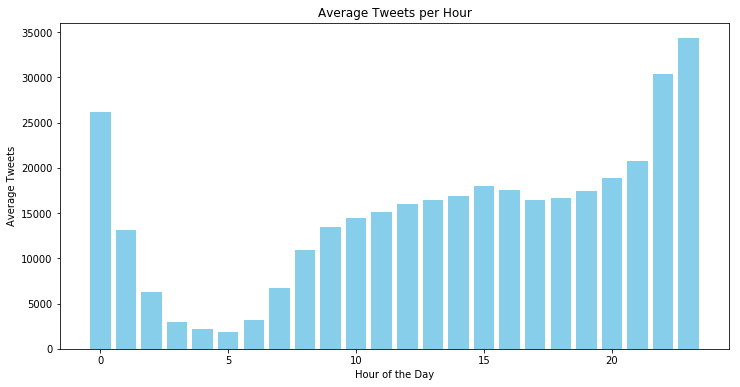

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the Spark DataFrame 'tweets_hour' to a Pandas DataFrame
tweets_hour_pd = tweets_hour.toPandas()

# Plot the bar graph
plt.figure(figsize=(12, 6))
plt.bar(tweets_hour_pd['hour'], tweets_hour_pd['tweets'], color='skyblue')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Tweets')
plt.title('Average Tweets per Hour')
plt.show()

### **Part 3.2:** Estratificat

En moltes ocasions el sampling homogeni no és adequat ja que la pròpia estructura de les dades fa que determinades poblacions estiguin sobrerepresentades. Aquest és el cas que observem en els tweets on les grans àrees urbanes estan sobrerepresentades si ho comparem amb el volum de població. En aquesta activitat veurem com aplicar aquesta tècnica al dataset de tweets, per obtenir un sampling que respecti la proporció de diputats per província.

A Espanya, el procés electoral assigna un volum de diputats a cada província que depèn de la població i d'un percentatge mínim assignat per llei. En el context Hive que hem creat prèviament (```hiveContext```) podem trobar una taula (``` province_28a```) que conté informació sobre les circumscripcions electorals. Carregueu aquesta taula en una variable amb nom ```province```.

In [55]:
# Load the 'province_28a' table using an SQL query into the 'province' variable
query = """ 
SELECT * FROM province_28a
"""
province = hiveContext.sql(query)

# Show the top 20 records of the 'province' table
province.limit(20).show()

+-----------+-----------+------------------+----------+---------+
|    capital|   province|              ccaa|population|diputados|
+-----------+-----------+------------------+----------+---------+
|     Teruel|     Teruel|            Aragón|     35691|        3|
|      Soria|      Soria|   Castilla y León|     39112|        2|
|    Segovia|    Segovia|   Castilla y León|     51683|        3|
|     Huesca|     Huesca|            Aragón|     52463|        3|
|     Cuenca|     Cuenca|Castilla-La Mancha|     54898|        3|
|      Ávila|      Ávila|   Castilla y León|     57697|        3|
|     Zamora|     Zamora|   Castilla y León|     61827|        3|
|Ciudad Real|Ciudad Real|Castilla-La Mancha|     74743|        5|
|   Palencia|   Palencia|   Castilla y León|     78629|        3|
| Pontevedra| Pontevedra|           Galicia|     82802|        7|
|     Toledo|     Toledo|Castilla-La Mancha|     84282|        6|
|Guadalajara|Guadalajara|Castilla-La Mancha|     84910|        3|
|      Ceu

In [56]:
assert province.count() == 52, "Incorrect answer"

Per fer un sampling estratificat el primer que hem de fer és determinar la fracció que volem assignar a cada categoria. En aquest cas volem una fracció que faci que la fracció de tweets diputat sigui igual per a totes les capitals de província. Hem de tenir en compte que la precisió de la geolocalització a Twitter és normalment a nivell de ciutat. Per això, per evitar incrementar la complexitat de l'exercici, utilitzarem els tweets en capitals de província com a proxy dels tweets en tota la província.

El primer que heu de fer és crear un taula ```info_tweets_province``` que ha de contenir:
- ***capital:*** nom de la capital de província.
- ***tweets:*** nombre de tweets geolocalitzats a cada capital
- ***diputats:*** diputats que assignats a la província.
- ***ratio_tweets_diputado:*** nombre de tweets per diputat.

Heu d'ordenar la llista per ```ratio_tweets_diputado``` en ordre ascendent.

***Nota:*** Podeu fer aquest exercici de moltes maneres, probablement la més fàcil és utilitzar la taula ```tweets_place``` que heu generat en l'apartat 2.2.1. Recordeu com utilitzar el ```join ()```

In [57]:
query = """
    SELECT A.capital, A.diputados, B.tweets, B.tweets/A.diputados as ratio_tweets_diputado
    FROM province_28a AS A 
    INNER JOIN (
        SELECT place.name as place, COUNT(user.id_str) as tweets
        FROM tweets28a_sample25
        WHERE place is not NULL 
        GROUP BY place.name 
        ORDER BY tweets DESC
    ) AS B ON A.capital = B.place
    ORDER BY ratio_tweets_diputado ASC
"""

info_tweets_province = hiveContext.sql(query)

info_tweets_province.limit(20).show()

+--------------------+---------+------+---------------------+
|             capital|diputados|tweets|ratio_tweets_diputado|
+--------------------+---------+------+---------------------+
|              Teruel|        3|     8|   2.6666666666666665|
|          Pontevedra|        7|    29|    4.142857142857143|
|              Zamora|        3|    23|    7.666666666666667|
|              Huesca|        3|    26|    8.666666666666666|
|             Segovia|        3|    28|    9.333333333333334|
|               Cádiz|        9|   108|                 12.0|
|               Soria|        2|    25|                 12.5|
|              Cuenca|        3|    39|                 13.0|
|         Ciudad Real|        5|    67|                 13.4|
|                Lugo|        4|    56|                 14.0|
|            Pamplona|        5|    77|                 15.4|
|                Jaén|        5|    86|                 17.2|
|         Guadalajara|        3|    56|   18.666666666666668|
|       

In [58]:
output = info_tweets_province.first()
maximum_ratio = floor(output.ratio_tweets_diputado * 100) / 100
assert output.capital == "Teruel" and output.tweets == 8 and output.diputados == 3, "Incorrect output"

En aquesta cas el primer que necessitarem és un diccionari amb nom ```ratios``` on cada capital de província és una clau i el seu valor associat és la fracció de tweets que anem a samplejar. En aquest cas el que volem és que el ràtio de tweets per cada diputat sigui similar per a cada capital de província.

Com volem que el sampling sigui el més gran possible i no volem que cap capital quedi infrarepresentada el ràtio de tweets per diputat serà el valor més petit podeu observar a la taula ```info_tweets_province```, que correspon a 11.66 tweets per diputat a Terol. Teniu aquest valor guardat a la variable ```maximum_ratio```.

*Nota:* El mètode ```collectAsMap ()``` transforma un PairRDD en un diccionari.

In [59]:
info_tweets_province=info_tweets_province.withColumn("ratio_tweets_diputado2",(info_tweets_province.diputados*maximum_ratio)/info_tweets_province.tweets)
ratios = info_tweets_province.select(info_tweets_province.capital,info_tweets_province.ratio_tweets_diputado2).rdd.collectAsMap()

In [60]:
assert ratios['Albacete'] == 0.12819277108433735, "Incorrect output"

Genereu una taula ```geo_tweets``` amb tots els tweets geolocalitzats.

In [61]:
query = """
SELECT place.name as place, text as tweets
FROM tweets28a_sample25
WHERE place IS NOT NULL
"""

# Execute the query and create the 'geo_tweets' DataFrame
geo_tweets = hiveContext.sql(query)

# Show the top 10 records of the 'geo_tweets' table
geo_tweets.limit(10).show()

+--------------------+--------------------+
|               place|              tweets|
+--------------------+--------------------+
|           Barcelona|@nasholop @PSOE N...|
|            Palencia|@luttor007 @Sexta...|
|              Murcia|@JORDIARCE Aquí s...|
|            Marbella|@DTrolera @Irene_...|
|           Barcelona|@SoyDeDerechas @S...|
|             Camargo|Ya puestos, Pablo...|
|             Calella|La mayor confront...|
|Sant Quirze del V...|@vox_es @Santi_AB...|
|San Cristóbal de ...|@Jaumeasens Podem...|
|             Sevilla|@PSOE @sanchezcas...|
+--------------------+--------------------+



Ara ja estem en disposició de fer el sampling estratificat per població. Per a això podeu utilitzar el mètode ```sampleBy ()```. Utilitzeu 42 com seed de el generador pseudoaleatori.

**Esquema**
```Python
seed = 42
sample = <FILL IN>
```

In [62]:
seed = 42

# Create the 'sample' DataFrame using sampleBy
sample = geo_tweets.sampleBy("place", ratios, seed)

# Show the top 20 records of the 'sample' DataFrame
sample.limit(20).show()

+--------------------+--------------------+
|               place|              tweets|
+--------------------+--------------------+
|          Pontevedra|Mañana domingo, @...|
|              Bilbao|@luisdemalaga64 @...|
|              Málaga|@PLSDE @SextaNoch...|
|              Málaga|@SextaNocheTV @In...|
|           Barcelona|@populares @PSOE ...|
|                León|Es vergonzoso #Ge...|
|         Ciudad Real|@OrbitaEduardo @D...|
|             Sevilla|Este tal Maroto e...|
|              Girona|@repubblica Vince...|
|Las Palmas de Gra...|@AlexisRavelo1 O ...|
|               Cádiz|Santiiiiiago Abas...|
|               Palma|Enhorabuena, @san...|
|              Toledo|Juan Guaido le de...|
|            Valencia|@carmenalvarez05 ...|
|              Lleida|     Molt interesant|
|            Zaragoza|Después del docto...|
|            Valencia|@PPCatalunya @cay...|
|             Badajoz|@Lechuzadenavia @...|
|             Almería|@sanchezcastejon ...|
|             Almería|@velardeda

Per visualitzar el resultat de l'sampling aneu a crear una taula ```info_sample``` que contingui la següent informació:
- ***capital:*** nom de la capital de província.
- *** tweets:*** nombre de tweets samplejats a cada capital
- ***diputats:*** diputats que assignats a la província.
- ***ratio_tweets_diputado:*** nombre de tweets per diputat.

Ordeneu la taula resultant per ordre de ```ratio_tweets_diputado``` ascendent.

In [63]:
sample.createOrReplaceTempView("sample")
info_tweets_province.createOrReplaceTempView("info_tweets_province")
query = """
SELECT s.place as capital, COUNT(s.tweets) AS tweets,tp.diputados, COUNT(s.tweets)/tp.diputados as ratio_tweets_diputado
FROM sample AS s 
JOIN info_tweets_province as tp ON s.place = tp.capital
GROUP BY s.place, tp.diputados
ORDER BY (ratio_tweets_diputado) ASC, diputados ASC
"""
info_sample = hiveContext.sql(query)

info_sample.limit(20).show()

+--------------------+------+---------+---------------------+
|             capital|tweets|diputados|ratio_tweets_diputado|
+--------------------+------+---------+---------------------+
|             Melilla|     1|        1|                  1.0|
|                Lugo|     4|        4|                  1.0|
|              Zamora|     5|        3|   1.6666666666666667|
|             Segovia|     5|        3|   1.6666666666666667|
|     Vitoria-Gasteiz|     7|        4|                 1.75|
|                León|     7|        4|                 1.75|
|           Santander|     9|        5|                  1.8|
|                Jaén|     9|        5|                  1.8|
|       San Sebastián|    11|        6|   1.8333333333333333|
|               Soria|     4|        2|                  2.0|
|              Cuenca|     6|        3|                  2.0|
|Las Palmas de Gra...|    16|        8|                  2.0|
|Castellón de la P...|    11|        5|                  2.2|
|       

In [64]:
output = info_sample.first()
assert output.capital == "Melilla" and output.tweets == 1  and output.diputados == 1 and output.ratio_tweets_diputado == 1.0, "Incorrect output"

Com veieu el sampling no és exacte, és una aproximació. Però com podeu imaginar apropar el sampling a la representativitat electoral de les regions és necessaris en molts casos.

Per comprovar-compteu primer tots els hashtags presents a la taula ```geo_tweets``` tal com hem fet en l'apartat 2.2.2 i ordeneu el resultat per nombre de tweets en ordre descendent. Deseu la taula en la variable `hashtagsTable`.

In [65]:
geo_tweets_rdd = geo_tweets.rdd
hashtags_geo = geo_tweets_rdd.map(lambda a: extract_hashtags(a[1])).filter(lambda x: len(x)>0)
hashtags_geo_splitted =  hashtags_geo.flatMap(lambda x: x.split("#"))
hashtags_geo_result = hashtagCount(hashtags_geo_splitted)
hashtagsTable =  hashtags_geo_result.toDF().withColumnRenamed('_1','hashtag').withColumnRenamed('_2','num')

hashtagsTable.limit(20).show()

+--------------------+----+
|             hashtag| num|
+--------------------+----+
|                #28A|1803|
|   #ElDebateDecisivo| 968|
|     #ELDEBATEenRTVE| 865|
|     #EquiparacionYa| 547|
|       #6AbrilMadrid| 450|
|         #ILPJusapoL| 429|
|         #HazQuePase| 411|
|#EleccionesGenera...| 359|
|        #ValorSeguro| 230|
|       #EleccionesL6| 228|
|   #DebateAtresmedia| 193|
| #LaEspañaQueQuieres| 175|
|#LaHistoriaLaEscr...| 170|
|         #DebateRTVE| 164|
|           #DebatTV3| 163|
|           #VotaPSOE| 158|
|#EleccionesGenerales| 151|
|             #España| 151|
|         #EspañaViva| 145|
|    #VamosCiudadanos| 138|
+--------------------+----+



In [66]:
output = hashtagsTable.first()
assert output.hashtag == "#28A" and output.num >= 1700, "Incorrect answer"

Compareu aquest resultat amb el que obtenim quan vam crear una taula ```hashtagsTable_sample``` on comptem els hashtags al mostra. Ordeneu la taula per nombre de tweets en ordre descendent.

In [67]:
sample_rdd = sample.rdd
hashtags_sample = sample_rdd.map(lambda a: extract_hashtags(a[1])).filter(lambda x: len(x)>0)
hashtags_sample_splitted =  hashtags_sample.flatMap(lambda x: x.split("#"))
hashtags_sample_result = hashtagCount(hashtags_sample_splitted)
hashtagsTable_sample =  hashtags_sample_result.toDF().withColumnRenamed('_1','hashtag').withColumnRenamed('_2','num')

hashtagsTable_sample.limit(20).show()

+--------------------+---+
|             hashtag|num|
+--------------------+---+
|                #28A| 42|
|   #ElDebateDecisivo| 27|
|     #ELDEBATEenRTVE| 15|
|         #HazQuePase| 13|
| #LaEspañaQueQuieres| 10|
|         #DebateRTVE|  8|
|#EleccionesGenera...|  6|
|#LaHistoriaLaEscr...|  5|
|    #EstamosMuyCerca|  5|
|                #vox|  4|
|           #DebatTV3|  4|
|          #Catalunya|  3|
|        #28AVotaPSOE|  3|
|        #ValorSeguro|  3|
| #LauraBorrasEsForça|  3|
|           #VotaPSOE|  3|
|                #VOX|  3|
|     #EquiparacionYa|  3|
|            #28Abril|  3|
|             #España|  3|
+--------------------+---+



In [68]:
output = hashtagsTable_sample.first()
assert output.hashtag == "#28A" and output.num >= 35, "Incorrect answer"

## **Part 4:** Introducció a les dades relacionals

El fet de treballar amb una base de dades que conté informació generada en una xarxa social ens permet introduir el concepte de dades relacionals. Podem definir dades relacionals com aquells en què les relacions entre les entitats constitueixen la base de dades. Sí aquestes relacions són binàries, relacions 1 a 1, podem representar les relacions com un graf compost per un conjunt de vèrtexs $\mathcal{V}$ i un conjunt d'arestes $\mathcal{E}$ que els relacionen.

En el cas de grafs que emergeixen de manera auto-organitzada l'estructura va més enllà dels grafs regulars que segurament coneixeu. Aquest tipus d'estructures es coneixen com [xarxes complexes](https://es.wikipedia.org/wiki/Red_compleja). L'estudi de l'estructura i propietats dinàmiques d'aquest tipus de xarxes ha contribuït a importants resultats en camps tan dispars com la física, la sociologia, l'ecologia o la medicina.

![Complex_network](https://images.squarespace-cdn.com/content/5150aec6e4b0e340ec52710a/1364574727391-XVOFAB9P6GHKTDAH6QTA/lastfm_800_graph_white.png?content-type=image%2Fpng)

En aquesta última part de la pràctica anem ha treballar amb aquest tipus de dades. En concret anem a modelar un dels possibles relacions presents en el dataset, la xarxa de retweets.

### **Part 4.1:** Generar la xarxa de retweets

#### **Part 4.1.1**: Construcció de la edgelist

El primer es demana que genereu la xarxa (el graf). Hi ha diverses maneres de representar una xarxa complexa, per exemple, si estem interessats a treballar-hi des del punt de vista teòric, la manera més habitual de representar-les és utilitzant una [matriu d'adjacència](https://ca.wikipedia.org/wiki/Matriu_d%27adjac%C3%A8ncia). En aquesta pràctica ens centrarem en l'aspecte computacional, una de les maneres de mes eficients (computacionalment parlant) de representar una xarxa és mitjançant la seva [*edge list*](https://en.wikipedia.org/wiki/Edge_list) , una taula que especifica la relació a parelles entre les entitats.

Les relacions poden ser bidireccionals o direccionals i tenir algun pes assignat o no (Weighted or unweighted). En el cas que ens ocupa, estem parlant d'una xarxa dirigida, un usuari retuiteja a un altre, i podem pensar-la tenint en compte quantes vegades això ha passat.

El primer que fareu per simplificar el còmput, és crear una mostra homogènia sense reemplaçament de l'1% dels tweets. Utilitzant els coneixements que heu après en l'apartat 3.1. Utilitzarem 42 com a valor per a la seed.

**Esquema**
```Python
seed = 42
sample = tweets.<FILL IN>
```

In [69]:
seed = 42
fraction = 0.01

sample = tweets.sample(fraction, seed)
print("Number of tweets sampled: {0}".format(sample.count()))

Number of tweets sampled: 63888


Creeu una taula ```edgelist``` amb la següent informació:
- ***src:*** usuari que retuiteja
- ***dst:*** usuari que és retuitejat
- ***weight:*** nombre de vegades que un usuari retuiteja a un altre.

Filtrar el resultat perquè contingui només les relacions amb un weight igual o major a dos.

In [70]:
sample.createOrReplaceGlobalTempView("sample_edge")

query = """
SELECT src,dst,weight FROM 
(
    SELECT 
        user.screen_name as src,
        retweeted_status.user.screen_name as dst,
        count(retweeted_status.user.screen_name) as weight
    FROM 
        global_temp.sample_edge
    WHERE retweeted_status IS NOT NULL 
    GROUP BY user.screen_name, retweeted_status.user.screen_name
) AS A
WHERE weight > 1
"""

edgelist=sqlContext.sql(query)

L = edgelist.count()

print("There are {0} edges on the network.".format(L))

There are 517 edges on the network.


In [71]:
assert L == 517, "Incorrect ouput"

#### **Part 4.1.2:** Centralitat de grau

Un dels descriptors més comuns en l'anàlisi de xarxes és el grau. El grau quantifica quantes arestes estan connectades a cada vèrtexs. En el cas de xarxes dirigides com la que acabem de crear aquest descriptor està descompost de:
- **n degree**: quantes arestes apunten el node
- **out degree**: quantes arestes surten de el node

Si fem un rànquing d'aquests valors obtindreu una mesura de centralitat, la [centralitat de grau](https://en.wikipedia.org/wiki/Centrality#Degree_centrality), de cadascun dels nodes.

Es demana que genereu una taula amb la següent informació:
- ***screen_name:*** nom de l'usuari.
- ***outDegree*** out degree de el node.

Ordenar la taula per out degree en ordre descendent.

In [72]:
# Calculate out-degrees
outDegree = edgelist.select("src","dst").groupBy("src")\
                     .agg({"dst":"count"})\
                     .orderBy("count(dst)",ascending=False)
outDegree = outDegree.withColumnRenamed("src","screen_name").withColumnRenamed("count(dst)","outDegree")

#Show results 
outDegree.limit(20).show()

+---------------+---------+
|    screen_name|outDegree|
+---------------+---------+
|    Manudocalin|        3|
|  antoniobb1953|        3|
|     carrasquem|        2|
|     Nacho_JISF|        2|
|       cukianaa|        2|
|    Karmaleonic|        2|
|       anap1958|        2|
| lanzarotejesus|        2|
| Maria_pilar_ga|        2|
|      Juancarfg|        2|
|    mariasvilas|        2|
|     ArwenPlaza|        2|
|    RosaMar6254|        2|
| ALFONSOLODEIRO|        2|
|     mirovira75|        2|
|      ppoleiros|        2|
|Migueln53227148|        2|
|    mariaje1956|        2|
|  mariarossa004|        2|
|      fatimar56|        2|
+---------------+---------+



In [73]:
output = outDegree.first()
assert output.screen_name == "Manudocalin" and output.outDegree == 3, "Incorrect output"

Es demana ara que genereu una taula `inDegree` con la informació:
- ***screen_name:*** nom de l'usuari.
- ***inDegree:*** in degree de el node.

Ordeneu la taula per in degree en ordre descendent.

In [74]:
# Calculate in-degrees
inDegree = edgelist.select("src","dst").groupBy("dst")\
                     .agg({"src":"count"})\
                     .orderBy("count(src)",ascending=False)
inDegree = inDegree.withColumnRenamed("dst","screen_name").withColumnRenamed("count(src)","inDegree")

# Show the result
inDegree.limit(20).show()

+---------------+--------+
|    screen_name|inDegree|
+---------------+--------+
|           PSOE|      45|
|   ahorapodemos|      37|
|   CiudadanosCs|      26|
|         vox_es|      26|
|      populares|      25|
|  Santi_ABASCAL|      18|
|Front_Republica|       9|
|      JuntsXCat|       9|
|  AlbanoDante76|       7|
|sanchezcastejon|       6|
|           KRLS|       6|
|    CastigadorY|       5|
|   Esquerra_ERC|       5|
|    protestona1|       5|
|     rcabrero75|       4|
|Pablo_Iglesias_|       4|
| AntonioMaestre|       4|
|socialistes_cat|       4|
|       marubimo|       4|
|       ivanedlm|       4|
+---------------+--------+



In [75]:
output = inDegree.first()
assert output.screen_name == "PSOE" and output.inDegree == 45, "Incorrect output"

### **Part 4.2:** Graphframes

Aquest tipus d'estructures és molt comú en molts datasets i el seu anàlisi cada vegada s'ha tornat més habitual. Per simplificar les operacions i l'anàlisi utilitzarem una llibreria específicament dissenyada per treballar en xarxes en sistemes distribuïts: [**Graphframes**](https://graphframes.github.io/graphframes/docs/_site/index.html) .

In [76]:
import sys
pyfiles = str(sc.getConf().get(u'spark.submit.pyFiles')).split(',')
sys.path.extend(pyfiles)
from graphframes import *

El primer que anem a fer és crear un objecte ```GraphFrame``` que contindrà tota la informació de la xarxa.

En un pas previ ja hem creat la *edge list* ara crearem una llista amb els vèrtexs. Crear una taula ```vértices``` que contingui una única columna ``` id``` amb els nom d'usuari de tots els vèrtexs. Recordeu que hi ha vèrtexs que pot ser que només tinguin arestes incidents i altres que potser no tinguin (heu de fer servir la informació de les dues columnes de la ```edgelist```). Recordeu que la llista de vèrtexs és un conjunt on no hi pot haver repetició d'identificadors!

In [77]:
vertices = outDegree.join(inDegree,['screen_name'],"fullouter")

# Show the count of nodes
N = vertices.count()
print("There are {0} nodes on the network.".format(N))

There are 682 nodes on the network.


In [78]:
assert N == 682, 'Incorrect output'

A l'igual que amb les arestes, podeu assignar atributs als vèrtexs. Genereu la taula `vertices_extended` fent un *inner join* per ``` id``` amb la taula ```user_info``` guardada en el context ``` hiveContext```. Ordeneu la taula resultant per followers en ordre descendent.


In [79]:
query = """
SELECT * 
FROM user_info
"""
user_info = hiveContext.sql(query)
user_info.limit(2).show()

vertices = vertices.withColumnRenamed("screen_name","id")
vertices_extended = vertices.join(user_info, ['id'],"inner")
vertices_extended = vertices_extended.orderBy(vertices_extended.followers.desc())
vertices_extended.limit(20).show()

+-------------+----+------+------------+---------+---------+
|           id|lang|tweets|total_tweets|following|followers|
+-------------+----+------+------------+---------+---------+
|000001Account|  en|     9|         107|       89|        2|
|     00000365|  en|     1|         754|      685|      189|
+-------------+----+------+------------+---------+---------+

+---------------+---------+--------+----+------+------------+---------+---------+
|             id|outDegree|inDegree|lang|tweets|total_tweets|following|followers|
+---------------+---------+--------+----+------+------------+---------+---------+
|        el_pais|     null|       3|  es|   880|      478720|      756|  6904062|
|Pablo_Iglesias_|     null|       4|  es|   160|       20949|     2831|  2297175|
|   ahorapodemos|     null|      37|  es|   858|      100336|     1571|  1381944|
|  Albert_Rivera|     null|       2|  es|   122|       54980|     2581|  1127429|
|        agarzon|     null|       1|  es|   134|       5826

In [80]:
output = vertices_extended.first()
assert output.id == "el_pais" and output.lang == "es" and output.followers == 6904062

UnaUn cop tenim l'edgelist i la llista de vèrtexs estem en disposició d'instanciar [un objecte ```GraphFrame```](https://graphframes.github.io/graphframes/docs/_site/api/python/graphframes.html ). Instancieu aquest objecte a la variable ```network```.

In [81]:
from graphframes import GraphFrame

# Assuming you have 'edgelist' and 'vertices' DataFrames
network = GraphFrame(vertices, edgelist)

In [82]:
assert type(network) == GraphFrame, "Incorrect answer"

L'objecte que acabeu de crear té molts atributs i mètodes per a l'anàlisis de xarxes [(comproveu l'API)](https://graphframes.github.io/graphframes/docs/_site/api/python/graphframes.html). Es demana que utilitzeu l'atribut ```inDegrees``` de l'objecte que acabeu de crear per, conjuntament amb la transformació ``` orderBy```, generar una taula `inDegreeGraph` ordenada descendentement per grau.



In [83]:
# Order by degree in descending order
inDegreeGraph = network.inDegrees.orderBy('inDegree', ascending=False)

# Show the resulting table
inDegreeGraph.limit(20).show()

+---------------+--------+
|             id|inDegree|
+---------------+--------+
|           PSOE|      45|
|   ahorapodemos|      37|
|   CiudadanosCs|      26|
|         vox_es|      26|
|      populares|      25|
|  Santi_ABASCAL|      18|
|Front_Republica|       9|
|      JuntsXCat|       9|
|  AlbanoDante76|       7|
|sanchezcastejon|       6|
|           KRLS|       6|
|    CastigadorY|       5|
|   Esquerra_ERC|       5|
|    protestona1|       5|
|     rcabrero75|       4|
|Pablo_Iglesias_|       4|
| AntonioMaestre|       4|
|socialistes_cat|       4|
|       marubimo|       4|
|       ivanedlm|       4|
+---------------+--------+



In [84]:
output = inDegreeGraph.first()
assert output.id == "PSOE" and output.inDegree == 45, "Incorrect answer"

Feu el mateix amb l'atribut ```outDegrees``` per, conjuntament amb la transformació ``` orderBy```,  generar una taula `outDegreeGraph` que conteng</mark> la informació del out degree en orden descendente.


In [85]:
# Calculate out-degrees
outDegreeGraph = network.outDegrees.orderBy("outDegree",ascending=False)

# Show the resulting table
outDegreeGraph.limit(20).show()

+---------------+---------+
|             id|outDegree|
+---------------+---------+
|    Manudocalin|        3|
|  antoniobb1953|        3|
|     carrasquem|        2|
|     Nacho_JISF|        2|
|       cukianaa|        2|
|    Karmaleonic|        2|
|       anap1958|        2|
| lanzarotejesus|        2|
| Maria_pilar_ga|        2|
|      Juancarfg|        2|
|    mariasvilas|        2|
|     ArwenPlaza|        2|
|    RosaMar6254|        2|
| ALFONSOLODEIRO|        2|
|     mirovira75|        2|
|      ppoleiros|        2|
|Migueln53227148|        2|
|    mariaje1956|        2|
|  mariarossa004|        2|
|      fatimar56|        2|
+---------------+---------+



In [86]:
output = outDegreeGraph.first()
assert output.id == "Manudocalin" and output.outDegree == 3, "Incorrect answer"

### **Part 5:** Vídeo resposta - Dataframes (2 punt)

En aquest apartat s'haurà de respondre a les qüestions que es mostren a continuació mitjançant un vídeo resposta d'entre 5 i 10 minuts. Heu de realitzar una gravació en la qual se us vegi la cara responent amb les vostres pròpies paraules a les qüestions. Heu de seguir els següents punts per a realitzar el vídeo:

Al principi del vídeo heu de dir el vostre nom i DNI mentre mostreu el DNI (que ha de veure's amb claredat i ser llegible).

Heu de respondre a les preguntes en l'ordre en el qual estan, comentant sempre al principi de cada resposta a quina pregunta us esteu referint.

En el cas de no respondre a alguna pregunta, heu d'indicar el quina pregunta no contesteu i el perquè.

### Preguntes

1 - Expliqueu com s'ha treballat en grup (organització de tasques, canals de comunicació, etc.) i que ha fet cada membre del grup.

2 - Explica les diferències entre un SGBDR i Apatxe Hive.

3 - Explica les relacions que existeix entre Apatxe Hive, el seu Metastore i HDFS. 

4 - Realitza una comparativa detallada entre Apatxe Hive i Impala. 

5 - Explica el funcionament de Spark Accumulator 

6 - Explica quines opcions et semblen més útils per a connectar-se a una "Font de dades" amb Spark SQL

#Pugeu el vídeo al canvas.

**2 -** Els sistemes de gestió de bases de dades relacionals (RDBMS) i Apache Hive són tecnologies de bases de dades, però tenen diferències significatives EN quant a casos d'ús, models de dades, llenguatges de consulta i escalabilitat. Aquestes són les diferències clau entre RDBMS i Apache Hive:

- **Model de dades**:
    - RDBMS: emmagatzemen dades en taules estructurades amb un esquema predefinit. Les dades s'organitzen en files i columnes, i les relacions entre taules normalment es defineixen mitjançant claus primàries i forasteres.
    
    - Apache Hive: dissenyat per treballar amb grans volums de dades estructurades i semiestructurades emmagatzemades al sistema de fitxers distribuïts de Hadoop (HDFS). El model de dades de Hive és més flexible i pot gestionar l'esquema a la lectura, cosa que li permet treballar amb diferents formats de dades.
    
- **Llengutage de consulta**:

    - RDBMS: utilitzen SQL  per consultar i manipular dades. 
    - Apache Hive: utilitza HiveQL (HQL), que és similar a SQL, però està dissenyat per consultar i analitzar dades a Hadoop. 
    
- **Casos d'ús**:

    - RDBMS: adequat per al processament transaccional i la gestió de dades estructurades com pot ser el comerç electrònic, gestió de relacions amb els clients (CRM) i sistemes financers.
    - Apache HIVE:  dissenyat per al processament per lots, l'emmagatzematge de dades i l'anàlisi de dades a gran escala.
    
- **Escalabilitat**:

    - RDBMS: solen ser escalables verticalment, la qual cosa significa que poden gestionar més càrregues afegint més recursos (p. ex., CPU, RAM) a un sol servidor.
    - Apache Hive: són escalables horitzontalment, el que el fa molt adequat per a entorns de grans dades. 
    
- **Emmagatzematge de dades**: 

    - RDBMS: emmagatzemen dades en motors d'emmagatzematge estructurats amb mecanismes d'indexació i recuperació de dades optimitzats.
    - Apache Hive: emmagatzema dades principalment a HDFS, un sistema de fitxers distribuït. 
    
- **Rendiment**:

    - RDBMS: estan optimitzats per a un rendiment en temps real de baixa latència en aplicacions transaccionals. Proporcionen operacions ràpides de lectura i escriptura per a càrregues de treball OLTP.
    - Apache Hive: optimitzat per al processament per lots i consultes analítiques, el que el fa més adequat per a càrregues de treball OLAP (processament analític en línia). 
    
- **Ecosistema**:

    - RDBMS: s'utilitzen  amb una àmplia gamma d'eines i plataformes per al desenvolupament d'aplicacions i l'anàlisi de dades.
    - Apache Hive: forma part de l'ecosistema Apache Hadoop i funciona perfectament amb altres components Hadoop com HDFS, HBase, Spark, Pig i molt més.

**3 -** Les relacions entre aquests components són les següents:

- **Hive i HDFS**:

    - Hive interactua amb HDFS per llegir i escriure dades. Les taules i les particions de Hive es mapegen a directoris i fitxers a HDFS.
    - Quan es crea una taula a Hive, proporciona una definició d'esquema lògic, però les dades reals s'emmagatzemen a HDFS. Normalment, cada taula correspon a un directori a HDFS.
    - Les consultes de Hive utilitzen el Metastore per comprendre l'estructura i la ubicació dels fitxers de dades a HDFS.
    - Les consultes de HiveQL les executa el Motor de Consultes de Hive, que les tradueix en tasques MapReduce o en altres motors d'execució com Apache Tez o Apache Spark. Aquestes tasques processen les dades a HDFS i retornen resultats.
    
- **Hive Metastore i HDFS**:

    - El Metastore de Hive emmagatzema metadades sobre les taules de Hive, les seves particions, els esquemes i més. Aquestes metadades inclouen informació sobre la ubicació dels fitxers de dades a HDFS.
    - El Metastore no emmagatzema les dades reals, però fa un seguiment de la ubicació de les dades a HDFS.
    - Quan creeu, modifiqueu o consulteu taules de Hive, el Metastore es consulta per proporcionar informació sobre els fitxers de dades a HDFS.
    
    
En resum, Apache Hive utilitza el Metastore de Hive per gestionar metadades sobre taules i particions, mentre que les dades reals s'emmagatzemen a HDFS. El Metastore ajuda als usuaris a interactuar i fer consultes sobre grans conjunts de dades a HDFS proporcionant un esquema estructurat i metadades. La integració entre Hive, el Metastore i HDFS és fonamental per fer accessibles als usuaris amb habilitats semblants a SQL l'anàlisi i la consulta de dades a gran escala.

**4 -** Apache Hive i Impala són dues tecnologies que pertanyen a l'ecosistema de Big Data d'Apache, i es fan servir per processar dades a gran escala. Tot i que tenen objectius semblants, hi ha algunes diferències importants entre elles:

- **Naturalesa del Motor de Consulta**:

    - Hive: Utilitza un motor de consulta retardada. Les consultes s'interpreten i s'executen en lot a través de tasques MapReduce, Tez o Spark. Per tant, pot tenir una latència més alta per a consultes interactives.
    - Impala: Utilitza un motor de consulta en temps real. Les consultes s'executen de manera directa i interactiva amb un rendiment semblant al d'un sistema d'obertura relacional (RDBMS).

- **Llenguatge de Consulta**:

    - Hive: Utilitza HiveQL, un llenguatge semblant a SQL que permet als usuaris realitzar consultes SQL en un entorn Hadoop.
    - Impala: També utilitza SQL, amb suport total per ANSI SQL.

- **Optimització**:

    - Hive: Les consultes s'optimitzen a través de tasques MapReduce, i poden requerir d'ajustaments manuals dels paràmetres per obtenir un rendiment òptim.
    - Impala: Utilitza un optimitzador d'arbre de consulta que permet optimitzar automàticament les consultes i ajustar-se a les característiques de l'arquitectura d'Impala.

- **Latència**:

    - Hive: Té una latència més alta, ja que les consultes es processen en lot i poden trigar més temps.
    - Impala: Ofereix una latència baixa per a consultes interactives. Les consultes es processen ràpidament, fent que sigui adequat per a entorns on la latència és crítica.

- **Processament en Memòria**:

    - Hive: No està dissenyat per a processament en memòria. Les dades solen emmagatzemar-se a HDFS i processar-se en disc.
    - Impala: Està dissenyat per processar dades en memòria. Això el converteix en una opció més eficaç per a consultes interactives ràpides.

- **Suport de Seguretat**:

    - Hive: Ofereix una integració sòlida amb Apache Ranger i suport d'integració amb LDAP.
    - Impala: També s'integra amb Apache Ranger i ofereix característiques avançades de seguretat.

- **Ús de Recursos**:

    - Hive: Utilitza una gestió més gran dels recursos, i les consultes poden ser més complexes per configurar.
    - Impala: És més senzill en la gestió dels recursos, i les consultes són més senzilles d'ajustar.

- **Casos d'ús**:

    - Hive: És adequat per al processament en lot, treball analític complex i integració amb eines d'obertura com Spark i MapReduce.
    - Impala: S'utilitza principalment per a consultes SQL interactives i ràpides, especialment en casos d'ús en què la latència és crítica.

**5 -** Un Spark Accumulator és una eina d'ús avançat que es fa servir en Apache Spark per a realitzar càlculs i recopilar dades de manera distribuïda en clústers. És especialment útil quan vols que diferents tasques o nodes d'execució processin dades i acumulin un resultat global sense que s'hagi de fer un pull de les dades de tots els nodes. La descripció del funcionament d'un Spark Accumulator seria la següent:

- **Creació d'un Accumulator**: Crear un Spark Accumulator per a diferents tipus de dades, com ara enters, decimals o altres tipus de dades.

- **Assignació de l'Accumulator a les Tasques**: l'assignarem a les tasques que s'executen en el clúster. Les tasques poden actualitzar el valor de l'Accumulator durant l'execució.

- **Processament Distribuït**: Les tasques, que es distribueixen en nodes diferents del clúster, processen les dades i actualitzen el valor de l'Accumulator com si fos una variable compartida. Aquesta actualització no requereix que es faci una etapa d'extracció (pull) de les dades.

- **Lectura del Resultat**: Un cop totes les tasques han finalitzat i l'Accumulator ha estat actualitzat a través del processament distribuït, es pot llegir el resultat final.

- **Conservació de la Persistència**: L'Accumulator manté la persistència dels seus valors i, per tant, s'hi pot accedir posteriorment després de la finalització d'una tasca. Els valors de l'Accumulator es poden fer servir per a estadístiques, seguiment o altres operacions.

Finalment, destacar que l'ús principal d'un Spark Accumulator és recopilar dades de manera distribuïda sense la necessitat de comunicació i extracció de dades explícites entre nodes. Això el converteix en una eina poderosa per al seguiment de resultats i el càlcul de dades globals en clústers d'Apache Spark. 

**6 -** En Spark SQL, hi ha diverses opcions per connectar-se a una font de dades. La seva elecció dependrà del tipus de font de dades i dels requisits específics del teu projecte. Algunes opcions que poden ser útils són:

- **JDBC (Java Database Connectivity)**: Si volem connectar-nos a una base de dades relacional com MySQL, PostgreSQL o Oracle, JDBC és una opció viable. Podem utilitzar la classe org.apache.spark.sql.DataFrameReader per llegir dades de bases de dades mitjançant JDBC.

- **Parquet**: Si la font de dades està en format Parquet, Spark SQL ofereix un suport nat al format. És un format molt eficient i amplament utilitzat en l'ecosistema de Hadoop.

- **CSV**: Per a fonts de dades en format CSV, Spark SQL ofereix una opció senzilla i eficient. Es pot llegir dades CSV especificant l'opció csv com a format.

- **Avro**: L'Avro és un format de dades binari molt útil per a fonts de dades que requereixen l'estructura de les dades. Spark SQL suporta Avro i permet llegir i escriure dades en aquest format.

- **JSON**:  Spark SQL també proporciona suport per a aquest format. Es pot llegir i escriure dades JSON amb facilitat.

- **Kafka**: Spark SQL permet connectar-se a un clúster de Kafka i llegir dades de temes de Kafka.

Destacar que a selecció de l'opció més adient depèn de les característiques de la font de dades, la seva complexitat i els requeriments específics del cas d'ús. Les opcions anteriors representen algunes de les opcions més comunes i versàtils que Spark SQL ofereix per a la connexió amb fonts de dades.

Video -> https://drive.google.com/file/d/1rkJH-jjvc2BfNPO3aQ1TUwC4y48l6LHX/view?usp=sharing